# Merging attributes from BioSample using word2vec
Adam Klie<br>
11/17/2019<br>
Script to create classes as output for neural net using similarities between attribute word embeddings

#### Import needed packages

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as sp
import spacy

#### Helper function definitions

In [3]:
def correlate_dataframes(df1, df2, metric = 'cosine' ):
    M = 1 - sp.distance.cdist(df1, df2, metric)
    return pd.DataFrame(data = M, index = df1.index, columns = df2.index)

#### Load data and embedding model

In [4]:
# Load embedding model
nlp = spacy.load('../data/wikipedia-pubmed-and-PMC-w2v')

/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [6]:
# Load attribute-value pairs
SRS_dir = "../data/allSRS_05_15_2018.pickle"
sra_dump_pickle_dir = "../data/sra_dump.pickle"
allSRS = pd.read_pickle(SRS_dir)
technical_meta_data_df = pd.read_pickle(sra_dump_pickle_dir)

#### Cap at 100 samples per study to avoid study bias and use only those attributes that are similar to defined classes

In [8]:
max_sample_per_study_n = 100
capped_samples = technical_meta_data_df.groupby('Study').head(n = max_sample_per_study_n)['Sample']
print("Number of samples left after capping: %d" % (len(capped_samples)))

Number of samples left after capping: 2348023


In [13]:
capped_m = allSRS.index.get_level_values(0).isin(capped_samples.values)

In [14]:
subset_SRS = allSRS[capped_m]

In [34]:
# Build a dataframe for the key (attribute) and values for each sample (srs)
SRS_df = pd.DataFrame(subset_SRS).reset_index()
SRS_df.columns = ['srs', 'attribute', 'value']

#### Sample attributes that occur greater than 100 times

In [16]:
# Take only attributes with more than 100 samples to compare
attribute_counts = SRS_df['attribute'].value_counts()
recurr_attrib = attribute_counts.index[attribute_counts > 100]
recurring_df = SRS_df[SRS_df.attribute.isin(recurr_attrib)]

In [17]:
print("There are %d recurring attributes (greater than 100 samples)" % len(recurr_attrib))

There are 2854 recurring attributes (greater than 100 samples)


In [18]:
# Randomly sample 100 per entities for generating entity vector
shuffled_df = recurring_df.sample(recurring_df.shape[0])
subset_df = shuffled_df.groupby('attribute').head(n = 100)
del recurring_df, shuffled_df

#### Get average embedding vector for each attribute

In [21]:
# Get vector representation for all attribute-value pairs randomly selected
docs = nlp.pipe(subset_df['value'].tolist())
vectors = [doc.vector for doc in docs]
doc_vector_df = pd.DataFrame(vectors, index = subset_df.set_index(['srs','attribute','value']).index).astype(float)

In [22]:
# Take average of each attribute and correlate them by cosine similarity
attribute_means = doc_vector_df.groupby('attribute').mean()
embedding_df = attribute_means[attribute_means.sum(axis=1).abs()>0]
corr_df = correlate_dataframes(embedding_df, embedding_df)

Text(0.5,1,'Distribution of cosine similarities of attributes')

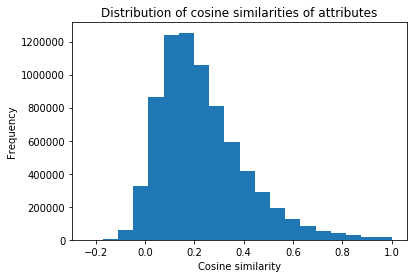

In [23]:
plt.hist(corr_df.unstack().dropna(), bins = 20)
plt.xlabel("Cosine similarity")
plt.ylabel('Frequency')
plt.title('Distribution of cosine similarities of attributes')

In [28]:
# Choose higher categories that will encompass merged attributes
similarity_threshold = 0.8
orig_grouping = pd.Series({'SCIENTIFIC_NAME':'Species',
                           'genotype':'Genotype',
                           'disease':'Disease state',
                           'cell type':'Cell type/tissue',
                           'tissue':'Cell type/tissue',
                           'geo_loc_name':'Geographical Location',
                           'treatment':'Treatment and conditions'})

simple_grouping = pd.Series({'SCIENTIFIC_NAME':'Species',
                            'cell type':'Cell type',
                            'genotype':'Genotype',
                            'disease':'Condition/Disease',
                            'tissue':'Tissue'})

eleven_class_grouping = pd.Series({'SCIENTIFIC_NAME':'Species',
                                   'strain':'Strain',
                                   'cell type':'Cell type',
                                   'genotype':'Genotype',
                                   'disease':'Condition/Disease',
                                   'tissue':'Tissue',
                                   'sex':'Sex',
                                   'age':'Age',
                                   'molecular data type':'Data type',
                                   'platform':'Platform',
                                   'protocol':'Protocol'})
grouping = simple_grouping
selected_seeds = grouping.index
model_iter = "simple"

In [29]:
# Find all attributes closest to the seed attributes by threshold
dataframe_list = []
for attribute in selected_seeds:
    if attribute == 'age':
        tmp_series = corr_df[attribute][corr_df[attribute].index.isin(['age', 'AGE', 'Age'])]
        tmp_df = tmp_series.sort_values(ascending = False).to_frame().reset_index()
    else:
        tmp_series = corr_df[attribute].sort_values(ascending = False)
        tmp_df = tmp_series[tmp_series>= similarity_threshold].to_frame().reset_index()
    tmp_df.columns = ['attribute','similarity']
    dataframe_list.append(tmp_df)

In [30]:
# Create a dataframe of entities that are similar
merged_df = pd.concat(dataframe_list, keys = selected_seeds, axis = 0)
merged_df.index.names=['GroupName','I']
merged_reset_df = merged_df.reset_index()
similar_df = merged_reset_df[merged_reset_df['similarity'] >= similarity_threshold]
similar_df['GroupName'] = grouping[similar_df['GroupName']].values

In [32]:
similar_df.to_csv('../results/entity_merging_{model}.csv'.format(model = model_iter))

#### Determine coverage increase with merging

In [35]:
similar_df['value count'] = SRS_df['attribute'].value_counts()[similar_df['attribute'].values].values

In [36]:
counts_df = similar_df[similar_df['attribute'].isin(['age', 'cell type', 'disease', 'molecular data type',
                                        'genotype', 'platform', 'protocol', 'sex', 'SCIENTIFIC_NAME',
                                        'strain', 'tissue'])].sort_values('GroupName').drop('I', axis = 1)
counts_df['merged count'] = similar_df.groupby('GroupName').sum()['value count'].values
counts_df['factor of increase'] = counts_df['merged count']/counts_df['value count']

In [37]:
display(counts_df)

,GroupName,attribute,similarity,value count,merged count,factor of increase
9,Cell type,cell type,1.0,92338,406554,4.402889
34,Condition/Disease,disease,1.0,21539,29716,1.379637
24,Genotype,genotype,1.0,73997,111392,1.505358
0,Species,SCIENTIFIC_NAME,1.0,1120707,1384957,1.235789
40,Tissue,tissue,1.0,267834,290836,1.085882
